In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from torch.utils.data import DataLoader ,Dataset
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier




In [150]:
m = pd.read_csv("../Data/train_147.csv", sep=",")
n = pd.read_csv("../Data/Functional.csv", sep=",")
b =pd.read_csv("../Data/Gen40.csv",sep=",")


y= pd.read_csv("../Data/T2D_ylab.txt")
y= y.iloc[:-1]
y = y[:].values
y= pd.DataFrame(y)
y = y.replace({"Control": 1, "T2D": 0})

TypeError: expected Tensor as element 0 in argument 0, but got DataFrame

In [154]:
# Extract the feature columns and label column
features1 = torch.tensor(m.values)
features2 = torch.tensor(n.values)
features3 = torch.tensor(b.values)

matrix_combined = torch.cat((features1, features2, features3), dim=1)
label = y.values

# Convert the feature columns to a PyTorch tensor
features_tensor = torch.tensor(matrix_combined)

# Convert the label column to a PyTorch tensor
label_tensor = torch.tensor(label)

# Create a TensorDataset from the feature and label tensors
dataset = torch.utils.data.TensorDataset(matrix_combined, label_tensor)

#Save it to tensor .pt objects
torch.save(label_tensor, '../Data/labels.pt')
torch.save(features_tensor, '../Data/features.pt')


/var/folders/wt/pl8gm0gs50d6vpk0nxfh07_h0000gn/T/ipykernel_70622/3578277840.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_tensor = torch.tensor(matrix_combined)


In [153]:
b.shape

(146, 50)

In [155]:
# Load the digits dataset and split it into training and test sets
X_train, X_test, y_train, y_test = train_test_split(matrix_combined, labels, random_state=42)

# Use t-SNE to reduce the dimensionality of the data to two dimensions
tsne = TSNE(n_components=2, random_state=0, n_iter=1000 )
X_tsne = tsne.fit_transform(X_train)

# Train a k-nearest neighbors classifier on the t-SNE-transformed data
knn = KNeighborsClassifier()
knn.fit(X_tsne, y_train)

# Evaluate the classifier on the test set
accuracy = knn.score(tsne.fit_transform(X_test),y_test)
print(f"Accuracy: {accuracy:.3f}")




/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Accuracy: 0.405


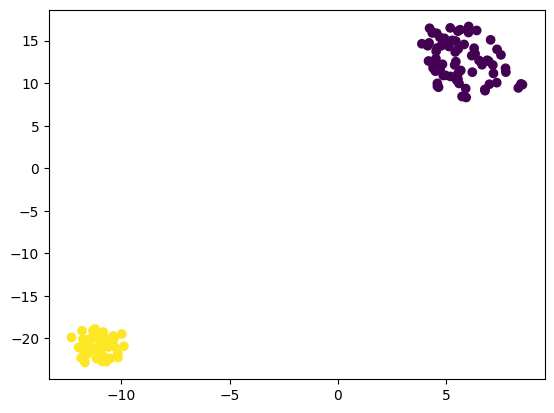

In [157]:
# Plot the t-SNE-transformed data with different colors for each digit class
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_train )
plt.show()


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


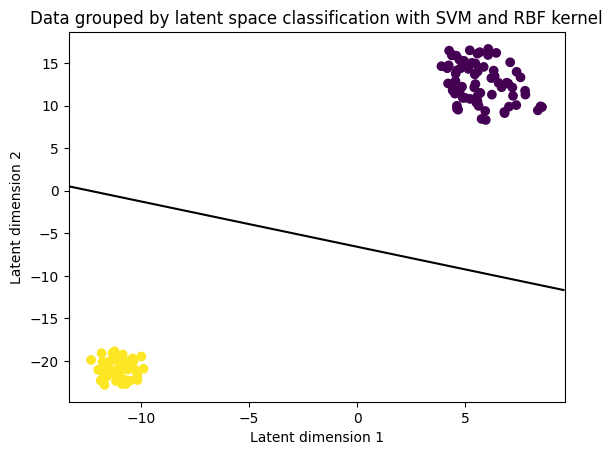

In [158]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_tsne, y_train)
# Create a scatter plot of the latent space coordinates, color-coded by group
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_train )

# Add axis labels and a title
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Data grouped by latent space classification with SVM and RBF kernel')

# Add the decision boundaries to the plot
xlim = plt.xlim()
ylim = plt.ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=100), np.linspace(*ylim, num=100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['-'])

# Show the plot
plt.show()

In [159]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
        # Decoder
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        mu, logvar = self.fc21(h1), self.fc22(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.reshape(-1, self.input_dim).float())
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [160]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.reshape(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [161]:
def train_vae1(model, eex, epochs, batch_size, learning_rate):
    train_loader =  DataLoader(dataset, batch_size=20, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, eex in enumerate(train_loader):
           
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data.float())
            loss = loss_function(recon_batch, data.float(), mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        print('Epoch: {} \t Loss: {:.6f}'.format(epoch+1, train_loss / len(train_loader.dataset)))

In [225]:
input_dim = 150 # Define the size of your input data
my_list = 2
z_dim = 150 # Define the size of the latent space
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim,my_list, z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 50

In [226]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/features.pt")
labels = torch.load("../Data/labels.pt")
nan_indices = torch.isnan(data)
data = torch.where(nan_indices, torch.tensor(0.0), data)


dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=50)

In [227]:
data.shape

torch.Size([146, 150])

In [228]:
train_vae1(model, dataloader, 50, 32, 1e-4)

Epoch: 1 	 Loss: 1227.723459
Epoch: 2 	 Loss: 1017.184878
Epoch: 3 	 Loss: 973.667608
Epoch: 4 	 Loss: 929.261184
Epoch: 5 	 Loss: 884.372599
Epoch: 6 	 Loss: 836.364592
Epoch: 7 	 Loss: 778.589590
Epoch: 8 	 Loss: 720.784026
Epoch: 9 	 Loss: 659.599730
Epoch: 10 	 Loss: 592.611736
Epoch: 11 	 Loss: 507.365455
Epoch: 12 	 Loss: 416.653237
Epoch: 13 	 Loss: 316.607295
Epoch: 14 	 Loss: 181.755074
Epoch: 15 	 Loss: 1.613006
Epoch: 16 	 Loss: -226.647327
Epoch: 17 	 Loss: -517.538277
Epoch: 18 	 Loss: -867.361154
Epoch: 19 	 Loss: -1368.785745
Epoch: 20 	 Loss: -2545.722456
Epoch: 21 	 Loss: -5213.364780
Epoch: 22 	 Loss: -8263.233519
Epoch: 23 	 Loss: -11033.498823
Epoch: 24 	 Loss: -14163.758669
Epoch: 25 	 Loss: -17389.664170
Epoch: 26 	 Loss: -20445.248930
Epoch: 27 	 Loss: -22578.883776
Epoch: 28 	 Loss: -25085.273973
Epoch: 29 	 Loss: -27662.786601
Epoch: 30 	 Loss: -30545.258990
Epoch: 31 	 Loss: -33225.402825
Epoch: 32 	 Loss: -36384.453339
Epoch: 33 	 Loss: -38839.211473
Epoch: 3

In [229]:
torch.save(VAE.state_dict(model), '../Model/vae_one_study2.pth')

In [230]:
#load Model and encode data
VAE.load_state_dict(model, torch.load('vae_one_study2.pth'))


<All keys matched successfully>

In [231]:
with torch.no_grad():
    z, _ = model.decode(closest_point_B.float())

ValueError: too many values to unpack (expected 2)

In [176]:
# Import dataset and classes needed in this example:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

# Import Gaussian Naive Bayes classifier:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [177]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=5)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1]
0.9333333333333333


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [178]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(z, labels, test_size=0.2, random_state=11)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0]
1.0


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


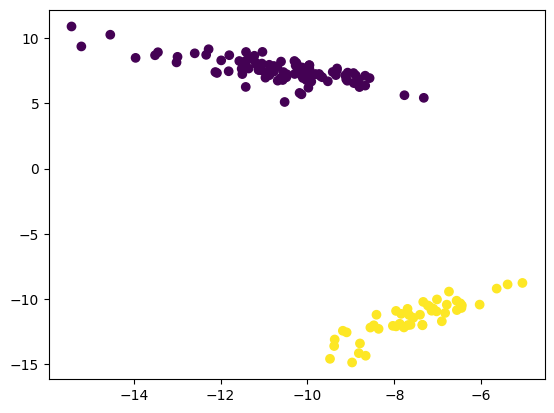

In [179]:
plt.scatter(z[:, 0], z[:, 1],c= labels)


In [180]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(z, labels)
# Evaluate the classifier on the validation set
y_val_pred = clf.predict(test)
val_accuracy = accuracy_score(test_labels, y_val_pred)
val_confusion_matrix = confusion_matrix(test_labels, y_val_pred)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [181]:
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation confusion matrix:\n{val_confusion_matrix}")

Validation accuracy: 1.0000
Validation confusion matrix:
[[20  0]
 [ 0 10]]


In [147]:
# Plot the decision boundaries and data points
x_min, x_max = test.min() - 0.1, test.max() + 0.1
y_min, y_max = test.min() - 0.1, test.max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))


In [182]:
from sklearn.svm import SVC

def classify_data_SVC(z):
    # Initialize the group labels randomly
    labels = np.random.randint(0, 2, size=z.shape[0])

    # Loop until the groups stabilize
    while True:
        # Train an SVM classifier with a non-linear kernel on the latent space coordinates and the group labels
        clf = SVC(kernel='rbf').fit(z, labels)

        # Predict the group labels for all data points
        pred_labels = clf.predict(z)

        # Check if the predicted labels match the current labels
        if np.array_equal(pred_labels, labels):
            break

        # If not, update the group labels
        labels = pred_labels

    # Return the final group labels
    return labels

In [183]:
labels = classify_data_SVC(z)

# Create a scatter plot of the latent space coordinates, color-coded by group
plt.scatter(z[:, 0], z[:, 1], c=labels)

# Add axis labels and a title
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Data grouped by latent space classification with SVM and RBF kernel')



# Show the plot
plt.show()

ValueError: The number of classes has to be greater than one; got 1 class

In [184]:

def classify_data_GNB(z):
    # Initialize the group labels randomly
    labels = np.random.randint(0, 2, size=z.shape[0])

    # Loop until the groups stabilize
    while True:
        # Train an SVM classifier with a non-linear kernel on the latent space coordinates and the group labels
        # Initialize classifier:
        clf = GaussianNB()

        # Train the classifier:     
        pred_labels =clf.fit(z,labels)
        
        # Make predictions with the classifier:
        pred_labels = gnb.predict(labels)

        # Check if the predicted labels match the current labels
        if np.array_equal(pred_labels, labels):
            break

        # If not, update the group labels
        labels = pred_labels

    # Return the final group labels
    return labels

In [185]:
labels = classify_data_GNB(z)

# Create a scatter plot of the latent space coordinates, color-coded by group
plt.scatter(z[:, 0], z[:, 1], c=labels)

# Add axis labels and a title
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Data grouped by latent space classification with SVM and RBF kernel')



# Show the plot
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0
 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

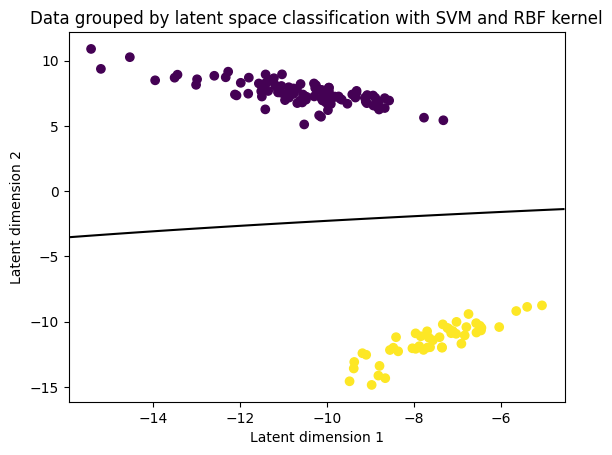

In [193]:
def classify_data(z):
    # Initialize the group labels randomly
    labels = np.random.randint(0, 2, size=z.shape[0])

    # Loop until the groups stabilize
    while True:
        # Train an SVM classifier with a non-linear kernel on the latent space coordinates and the group labels
        clf = SVC(kernel='rbf').fit(z, labels)

        # Predict the group labels for all data points
        pred_labels = clf.predict(z)

        # Check if the predicted labels match the current labels
        if np.array_equal(pred_labels, labels):
            break

        # If not, update the group labels
        labels = pred_labels

    # Return the final group labels and the trained classifier
    return labels, clf

# Generate the group labels and the trained classifier using the classify_data function with SVM and RBF kernel
labels, clf = classify_data(z)

# Create a scatter plot of the latent space coordinates, color-coded by group
plt.scatter(z[:, 0], z[:, 1], c=labels)

# Add axis labels and a title
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Data grouped by latent space classification with SVM and RBF kernel')

# Add the decision boundaries to the plot
xlim = plt.xlim()
ylim = plt.ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=100), np.linspace(*ylim, num=100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['-'])

# Show the plot
plt.show()

In [194]:

# first, find the indices of the points in class A and class B
indices_A = np.where(labels == 1)[0]
indices_B = np.where(labels == 0)[0]

In [197]:
# extract the data points (Tensors) in class A and class B
points_A = data[indices_A]
points_B = data[indices_B]

In [201]:
# let's say you're interested in finding the closest point in class B to the first point in class A
point_A = points_A[0]
distances = torch.norm(points_B - point_A, dim=1)
min_distance = torch.min(distances)
closest_point_B = points_B[torch.argmin(distances)]

In [ ]:
# calculate the difference between the two points
difference = closest_point_B - point_A

print(f"The minimum Euclidean distance between a point in class A and a point in class B is {min_distance}.")
print(f"The closest point in class B to the first point in class A is {closest_point_B}.")
print(f"The difference between the two points is {difference}.")

In [204]:

indices = torch.where(torch.all(data == closest_point_B, axis=1))[0]


In [207]:
data[99]

tensor([0.0000, 1.9539, 1.0659, 0.0775, 0.0000, 0.4768, 0.0000, 0.0270, 0.0000,
        1.5593, 3.4844, 1.9633, 0.3306, 0.0000, 0.0000, 0.0000, 1.8488, 0.0000,
        1.3271, 0.0000, 0.0000, 0.0000, 0.0000, 1.9618, 0.0000, 3.0954, 1.7719,
        0.0000, 2.6623, 1.8815, 0.0000, 0.0000, 0.1827, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3736, 0.5692, 2.3507, 0.0347, 0.0000, 3.6566, 1.9310, 0.0000,
        0.0000, 2.7296, 2.5002, 0.0000, 1.0050, 2.2519, 0.0000, 0.0000, 1.2691,
        0.0000, 0.0000, 0.0000, 2.5403, 0.0000, 1.4951, 1.4841, 1.2158, 3.4579,
        0.0000, 0.2574, 1.5570, 0.0000, 3.4918, 1.1940, 0.0000, 0.0000, 0.1771,
        0.0000, 0.0000, 1.9311, 1.8469, 4.2595, 2.4102, 1.9308, 0.0000, 1.5183,
        4.4092, 0.0000, 0.4729, 0.0000, 0.2926, 2.7506, 0.0000, 0.0000, 2.1808,
        6.7957, 3.5056, 2.4417, 0.0000, 0.0000, 0.1032, 0.8042, 0.0991, 0.1461,
        3.3183, 2.2519, 0.0000, 0.0000, 1.2691, 0.0000, 0.0000, 0.0000, 2.5403,
        0.0000, 1.4951, 1.4841, 1.2158, 

In [236]:
single_tensor = torch.tensor(data[99])  # or any other single tensor
#single_tensor = single_tensor.unsqueeze(0)  # add an extra dimension
decoded_tensor = model.decode(single_tensor.unsqueeze(0).float())  # pass to the decoder of your VAE

/var/folders/wt/pl8gm0gs50d6vpk0nxfh07_h0000gn/T/ipykernel_70622/90800536.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single_tensor = torch.tensor(data[99])  # or any other single tensor


In [239]:
dataset

In [241]:
import torch
from scipy.spatial.distance import cdist


# compute Euclidean distances between decoded tensor and all original tensors
distances = cdist(decoded_tensor.detach().numpy(), data.numpy(), metric='euclidean')

# find index of the original tensor with the smallest distance
index = torch.argmin(torch.from_numpy(distances))

# select the original tensor with the smallest distance
original_sample = dataset[index]

In [243]:
index

tensor(142)